In [1]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables as tb
# import warnings
# warnings.filterwarnings("ignore")
# sys.path.insert(0, '../forecaster/src/')

We suppose a simulation has been executed and thus, all the data is available. We can take the prediction date reading the simulation file:

In [2]:
now_dt: datetime = datetime.datetime.strptime('2010-03-22 16:00:00', "%Y-%m-%d %H:%M:%S")
farm_name: str = 'Oahu'
sensors = ["ap1","ap3","ap4","ap5","ap6","ap7","dh1","dh2","dh3","dh4","dh5","dh6","dh7","dh8","dh9","dh10","dh11"]

Now we extract input data and predictions (filepaths are always the same):

In [5]:
data_path = f'../data/output/DataCenter/{farm_name}/prediction-input.h5'
prediction_path = f'../data/output/DataCenter/{farm_name}/prediction-output.h5'
n_sensors = 17
n_horizons = 4
n = now_dt.strftime('%Y-%m-%d')
with tb.open_file(prediction_path, 'r') as h5_preds, tb.open_file(data_path, 'r') as h5_data:
    timestamps = h5_preds.root.DataCenter[farm_name][n]._v_children.keys()
    timestamps = list(timestamps)
    preds = np.empty((len(timestamps), n_sensors, n_horizons))
    persistence = np.empty((len(timestamps), n_sensors, n_horizons))
    data = np.empty((len(timestamps), n_sensors))
    for idx, t in enumerate(timestamps):
        preds[idx] = h5_preds.root.DataCenter[farm_name][n][t][:]
        data[idx] = h5_data.root.DataCenter[farm_name][n][idx,1:]
        for hh,h in enumerate([1,11,31,61]):
            if idx-h > 0: persistence[idx,:,hh] = h5_data.root.DataCenter[farm_name][n][idx-h,1:]
            else: persistence[idx,:,hh] = np.nan
    sensors = h5_data.root.DataCenter[farm_name]._v_attrs['columns'][1:]
times = [pd.to_datetime(d) for d in timestamps]

Plot predictions and real data for sensor ap1:

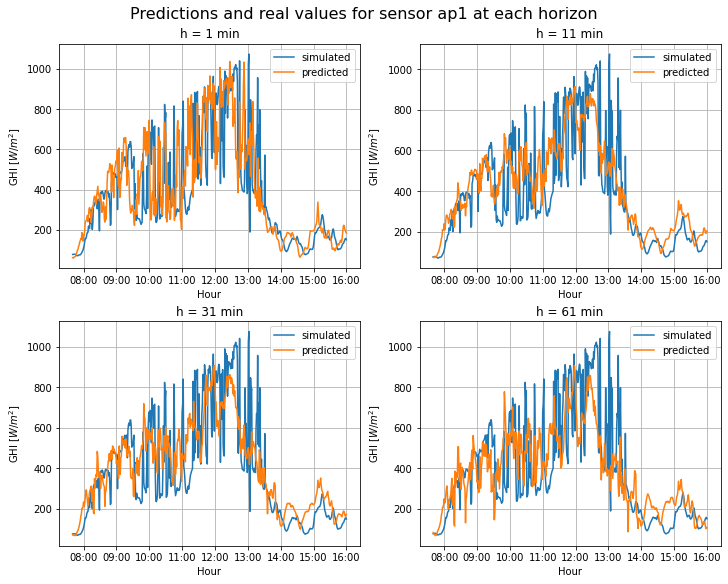

In [11]:
sensor = 0

fig,ax = plt.subplots(2,2, figsize=(10,8),constrained_layout = True)
fig.suptitle('Predictions and real values for sensor {} at each horizon'.format(sensors[sensor]), fontsize=16)
for idx,h in enumerate(['1 min','11 min','31 min','61 min']):
    ax[idx//2,idx%2].set_title(label='h = {}'.format(h))
    ax[idx//2,idx%2].plot(times, data[:,sensor], label='simulated')
    ax[idx//2,idx%2].plot(times, preds[:,sensor,idx], label='predicted')
    ax[idx//2,idx%2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[idx//2,idx%2].grid()
    ax[idx//2,idx%2].legend()
    ax[idx//2,idx%2].set_ylabel('GHI $[W/m^2]$')
    ax[idx//2,idx%2].set_xlabel('Hour') #, fontsize=12)

Plot predictions and real data for all the sensors:

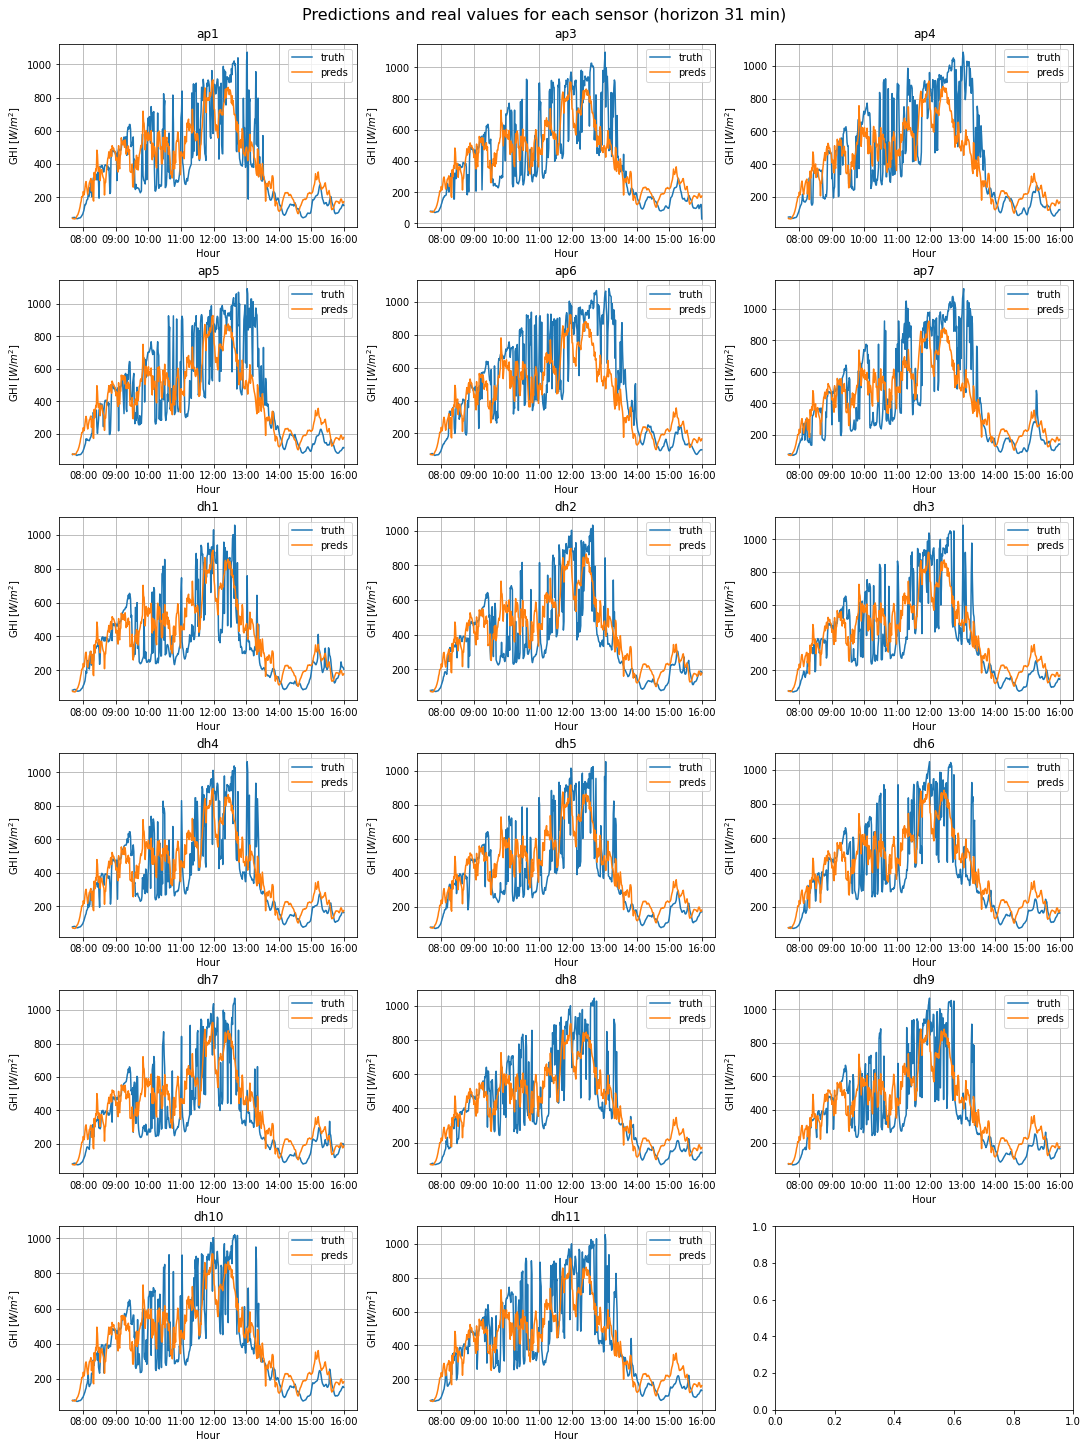

In [12]:
horizons = {0:1,1:11,2:31,3:61}
h = 2

fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
fig.suptitle('Predictions and real values for each sensor (horizon {} min)'.format(horizons[h]), fontsize=16)
for i in range(n_sensors):
    ax[i//3,i%3].set_title(label=sensors[i])
    ax[i//3,i%3].plot(times, data[:,i], label='truth')
    ax[i//3,i%3].plot(times, preds[:,i,h], label='preds')
    ax[i//3,i%3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i//3,i%3].grid()
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_ylabel('GHI $[W/m^2]$')
    ax[i//3,i%3].set_xlabel('Hour') #, fontsize=12)

Difference between predicted and real values for each sensor (horizon 11 min)

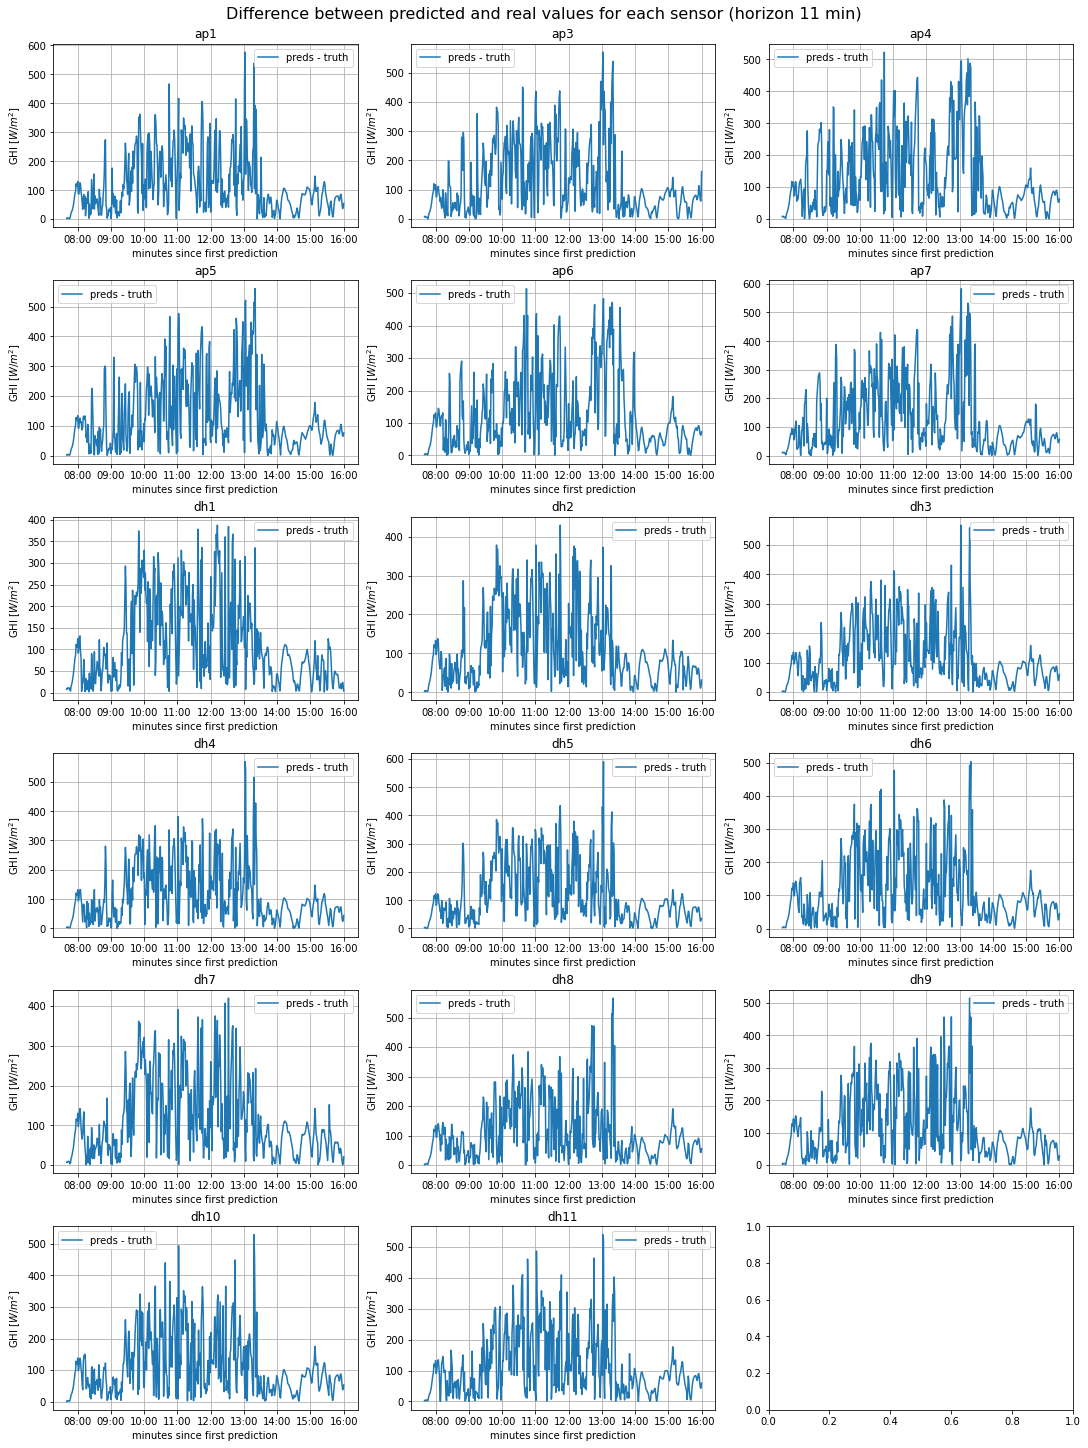

In [13]:
h =1

fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
fig.suptitle('Difference between predicted and real values for each sensor (horizon {} min)'.format(horizons[h]), fontsize=16)
for i in range(17):
    ax[i//3,i%3].set_title(label=sensors[i])
    ax[i//3,i%3].plot(times, np.abs(preds[:,i,h] - data[:,i]), label='preds - truth')
    ax[i//3,i%3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i//3,i%3].grid()
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_ylabel('GHI $[W/m^2]$')
    ax[i//3,i%3].set_xlabel('minutes since first prediction')

Dataframes for MAE and RMSE for each horizon and each sensor:

In [14]:
df = pd.DataFrame(columns=[*sensors, 'mean'], index=['1 min','11 min','31 min','61 min', 'mean'])
for idx,i in enumerate(['1 min','11 min','31 min','61 min']):
    df.loc[i] = [*np.nanmean(np.abs(preds[...,idx] - data), axis=0).round(2), np.nanmean(np.abs(preds[...,idx] - data), axis=(0,1)).round(2)]  
df.loc['mean'] = [
    *np.mean([np.abs(preds[...,j] - data) for j in range(4)], axis=(0,1)).round(2),
    np.mean([np.abs(preds[...,j] - data) for j in range(4)]).round(2)]
df.index.name = 'MAE'
df.T

MAE,1 min,11 min,31 min,61 min,mean
ap1,122.72,117.83,119.96,128.34,122.22
ap3,134.28,124.5,130.98,144.82,133.64
ap4,134.78,131.63,139.4,157.22,140.76
ap5,136.92,131.32,140.61,155.32,141.04
ap6,125.76,126.16,141.59,162.93,139.11
ap7,133.59,130.0,138.67,154.73,139.25
dh1,106.8,107.81,115.58,125.07,113.81
dh2,110.5,111.19,114.42,123.9,115.0
dh3,122.85,116.33,119.31,126.77,121.32
dh4,122.39,113.94,114.74,121.19,118.06


In [15]:
df = pd.DataFrame(columns=[*sensors, 'mean'], index=['1 min','11 min','31 min','61 min', 'mean'])
for idx,i in enumerate(['1 min','11 min','31 min','61 min']):
    df.loc[i] = [*np.sqrt(np.nanmean((preds[...,idx] - data)**2, axis=0)).round(2), np.sqrt(np.nanmean((preds[...,idx] - data)**2, axis=(0,1))).round(2)]  
df.loc['mean'] = [
    *np.sqrt(np.mean([(preds[...,j] - data)**2 for j in range(4)], axis=(0,1))).round(2),
    np.sqrt(np.mean([(preds[...,j] - data)**2 for j in range(4)])).round(2)]
df.index.name = 'RMSE'
df.T

RMSE,1 min,11 min,31 min,61 min,mean
ap1,177.65,154.83,156.94,171.13,165.41
ap3,190.86,168.48,175.71,195.86,183.06
ap4,191.41,176.26,186.47,213.68,192.44
ap5,195.61,175.92,187.59,209.67,192.59
ap6,178.89,169.59,189.32,221.6,190.86
ap7,193.46,176.33,186.87,210.1,192.08
dh1,158.81,142.69,149.65,161.65,153.39
dh2,162.08,145.09,147.37,160.1,153.84
dh3,179.89,152.09,155.1,169.65,164.57
dh4,177.53,150.21,150.77,164.09,161.04


Forecasting Skill of the model when compared with persistent: 

In [16]:
proposed_mae, base_mae = np.empty(4), np.empty(4)
proposed_rmse, base_rmse = np.empty(4), np.empty(4)
for idx,i in enumerate([1,11,31,61]):
    proposed_mae[idx] = np.nanmean(np.abs(preds[i+1:,:,idx] - data[i+1:]), axis=(0,1))
    base_mae[idx] = np.nanmean(np.abs(persistence[i+1:,...,idx] - data[i+1:]), axis=(0,1))
    proposed_rmse[idx] = np.nanmean(np.sqrt(np.nanmean((preds[i+1:,:,idx] - data[i+1:])**2, axis=0)),axis=0)
    base_rmse[idx] =np.nanmean(np.sqrt(np.nanmean((persistence[i+1:,...,idx] - data[i+1:])**2, axis=0)),axis=0) 

skill_mae = (1 - proposed_mae/base_mae)*100
skill_rmse = (1 - proposed_rmse/base_rmse)*100
skill = pd.DataFrame([skill_mae.round(2),skill_rmse.round(2)])
skill = skill.set_axis(['percentage skill MAE','percentage skill RMSE'], axis=0).set_axis(['1 min','11 min','31 min','61 min'], axis=1)
skill

,1 min,11 min,31 min,61 min
percentage skill MAE,-105.95,12.71,32.36,44.93
percentage skill RMSE,-47.22,22.65,33.37,42.97
